# Descargar los datos

Los datos se unen para formar un solo dataframe que facilite su procesamiento juntando cada URL con su respectivo review

In [2]:
import glob
import pandas as pd
import matplotlib.pyplot as plt 
import json 
import random
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
#Read the txt into a list and then into a dataframe
def read_txt(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        #Delete the /usercomments part of the url and leave the rest
        lines = [re.sub('/usercomments\n', '', line) for line in lines]
    return lines

path = 'data/reviews_url.txt'

urls = read_txt(path)

urls_df = pd.DataFrame(urls, columns=['url'])

print (urls_df.head(10))

                                   url
0  http://www.imdb.com/title/tt0064354
1  http://www.imdb.com/title/tt0100680
2  http://www.imdb.com/title/tt0100680
3  http://www.imdb.com/title/tt0100680
4  http://www.imdb.com/title/tt0047200
5  http://www.imdb.com/title/tt0893406
6  http://www.imdb.com/title/tt0893406
7  http://www.imdb.com/title/tt0893406
8  http://www.imdb.com/title/tt0893406
9  http://www.imdb.com/title/tt0893406


In [3]:
#Read all files from a folder and save them in a dataframe
path = 'data/reviews/'
all_files = glob.glob(path + "/*.txt")

reviews = []

for filename in all_files:
    with open(filename, 'r') as f:
        data = f.read()
        reviews.append(data)

#Clean non alphanumeric characters in each review from the reviews list and replace them with a space
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    return text

reviews = [clean_text(review) for review in reviews]

#Create a dataframe with the reviews
reviews_df = pd.DataFrame(reviews, columns=['review'])

print(reviews_df.head(10))

KeyboardInterrupt: 

In [4]:
#Join the dataframe with the urls and the reviews
data = pd.concat([urls_df, reviews_df], axis=1)

#Save the data to a csv file
data.to_csv('data/data.csv', index=False)

#Create a smaller file with only 30% of the data
data_smaller = data.sample(frac=0.1, random_state=42)

#Save the smaller file to a csv file
data_smaller.to_csv('data/data_smaller.csv', index=False)

print(data.head(10))

                                   url  \
0  http://www.imdb.com/title/tt0064354   
1  http://www.imdb.com/title/tt0100680   
2  http://www.imdb.com/title/tt0100680   
3  http://www.imdb.com/title/tt0100680   
4  http://www.imdb.com/title/tt0047200   
5  http://www.imdb.com/title/tt0893406   
6  http://www.imdb.com/title/tt0893406   
7  http://www.imdb.com/title/tt0893406   
8  http://www.imdb.com/title/tt0893406   
9  http://www.imdb.com/title/tt0893406   

                                              review  
0  working with one of the best shakespeare sourc...  
1  well   tremors i  the original started off in ...  
2  ouch  this one was a bit painful to sit throug...  
3  i ve seen some crappy movies in my life  but t...  
4   carriers  follows the exploits of two guys an...  
5  i had been looking forward to seeing this film...  
6  effect s  without cause is generally not possi...  
7  this picture started out with good intentions ...  
8  i chose to see this movie because it go

In [4]:
# In case the data.csv file exists, read it and convert it to df
try:
    data = pd.read_csv('data/data.csv')
except:
    print('File not found')

In [5]:
#Check that every url has a review
print(data.isnull().sum())

url       0
review    0
dtype: int64


In [6]:
#iloc is used to select rows and columns by number, in the order that they appear in the data frame
x = data.iloc[0]
x

url                     http://www.imdb.com/title/tt0064354
review    working with one of the best shakespeare sourc...
Name: 0, dtype: object

In [6]:
x['review']

'working with one of the best shakespeare sources  this film manages to be creditable to it s source  whilst still appealing to a wider audience  br    br   branagh steals the film from under fishburne s nose  and there s a talented cast on good form '

### Utilities in case of a problematic format

In [8]:
#This would be necessary in case the contents of a column contained more than a single string
#So we could join the strings into a single one

#j = json.loads(x['review'])
#j
#' '.join(''.join(jj['name'].split()) for jj in j)

In [9]:
#This too would be necessary in case the contents of a column contained more than a single string

# convert the relevant data for each movie into a single string
# to be ingested by TfidfVectorizer
def urls_and_reviews_to_string(row):
  urls = json.loads(row['url'])
  urls = ' '.join(''.join(j['name'].split()) for j in urls)

  reviews = json.loads(row['review'])
  reviews = ' '.join(''.join(j['name'].split()) for j in reviews)
  return "%s %s" % (urls, reviews)

# a) 100 random reviews sample

In [9]:
# Select a random sample of 100 reviews from the data
random_sample_df = data.sample(n=100, random_state=42)
#random_state = 42 means that the results will be the same every time we run the code

# Show the first few rows of the sample
random_sample_df.head()

,url,review
1766,http://www.imdb.com/title/tt0375560,scotty grant cramer who would go on to star ...
11919,http://www.imdb.com/title/tt0101327,this movie is complete crap avoid this waste ...
8909,http://www.imdb.com/title/tt0949379,i honestly had somewhat high expectations when...
4963,http://www.imdb.com/title/tt0845463,your first clue that this is a cheesy movie is...
10099,http://www.imdb.com/title/tt0463392,alright i got passed the horrible acting i g...


# b) Cálculo de tf,df,idf,tf-idf

### This was the first approach where only basic stopwords are considered though custom stopwords are set but not passed to the vectorizer object

The reviews are joined together in case there is more than one per url.

In [9]:
import numpy as np 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stopwords = set(['movie', 'film', 'br', 'movies'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

#create a tf-idf vectorizer object
#max_features: build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')

# Groups the reviews by URL in case there is more than one review per URL
grouped = random_sample_df.groupby('url')['review'].apply(' '.join).reset_index()

grouped.head()

,url,review
0,http://www.imdb.com/title/tt0025173,i have never seen a movie as bad as this it i...
1,http://www.imdb.com/title/tt0028174,in this movie joe pesci slams dunks a basketb...
2,http://www.imdb.com/title/tt0028358,my comments on this movie have been deleted tw...
3,http://www.imdb.com/title/tt0035096,i rented this movie because i was browsing thr...
4,http://www.imdb.com/title/tt0065761,you have to respect this movie it may be jus...


In [10]:
# Count if there were any changes with the grouping
unique_urls_before_grouping = len(random_sample_df['url'].unique())
unique_urls_after_grouping = len(grouped['url'].unique())

# Count the number of reviews for each URL before grouping
review_count_per_url = random_sample_df['url'].value_counts()

# Show the number of unique URLs and some statistics on review counts per URL
unique_urls_before_grouping, unique_urls_after_grouping, review_count_per_url.describe()

(98,
 98,
 count    98.000000
 mean      1.020408
 std       0.142119
 min       1.000000
 25%       1.000000
 50%       1.000000
 75%       1.000000
 max       2.000000
 Name: count, dtype: float64)

In [11]:
#Print the urls with the most reviews
review_count_per_url.head(10)

url
http://www.imdb.com/title/tt0102585    2
http://www.imdb.com/title/tt0463392    2
http://www.imdb.com/title/tt0088028    1
http://www.imdb.com/title/tt0770810    1
http://www.imdb.com/title/tt0196267    1
http://www.imdb.com/title/tt0099742    1
http://www.imdb.com/title/tt0106834    1
http://www.imdb.com/title/tt0783518    1
http://www.imdb.com/title/tt0211181    1
http://www.imdb.com/title/tt0284137    1
Name: count, dtype: int64

In [12]:
#Perform the TF-IDF vectorization on the reviews
X = tfidf.fit_transform(grouped['review'])
X

<98x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 6278 stored elements in Compressed Sparse Row format>

In [13]:
#Get the feature names of the vectorized reviews. 
#Feature names are the words that make up the columns of the matrix
#get_feature_names_out() returns a numpy array 
features_x = np.array(tfidf.get_feature_names_out()) 

#Calculate the TF,DF, IDF, and TF-IDF 
tf = np.sum(X.toarray(), axis=0)   
df = np.sum(X.toarray()>0, axis=0)
#tfidf.idf_ is the inverse document frequency vector
idf = tfidf.idf_

In [14]:
# Combine the calculations into a DataFrame
tfidf_df = pd.DataFrame({'Term': features_x, 'TF': tf, 'DF': df, 'IDF': idf})
tfidf_df['TF-IDF'] = tfidf_df['TF'] * tfidf_df['IDF']

# Sort the DataFrame by TF-IDF in descending order and take the top 10 terms
top_10_tfidf = tfidf_df.sort_values('TF-IDF', ascending=False).head(10)

top_10_tfidf

,Term,TF,DF,IDF,TF-IDF
166,br,13.885431,63,1.436237,19.942766
926,movie,7.030514,60,1.484246,10.435012
521,film,5.732469,59,1.500775,8.603147
102,bad,3.539264,39,1.906240,6.746689
750,just,3.557915,44,1.788457,6.363179
808,like,3.499194,47,1.723919,6.032326
927,movies,2.352648,23,2.417066,5.686505
677,horror,1.747701,12,3.030170,5.295833
595,good,2.790123,40,1.881548,5.249750
1185,plot,2.154158,23,2.417066,5.206742


**Turns out there's in fact irrelevant words being considered, those will be considered domain specific stopwords**

Still, the results are shown for demonstration purposes

In [15]:
#Show a sample of X
X_demo = X.toarray()[:20, :40]
features_demo = features_x[:40]

X_df_demo = pd.DataFrame(X_demo, columns=features_demo)

X_df_demo

,10,100,12,13,13th,15,16,1963,2006,300,...,actually,adaptation,addict,adds,admit,adopted,adult,adults,adventures,advice
0,0.0,0.288453,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.057352,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.000000,0.112677,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.021429,0.0,0.0
5,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [16]:
# Calculate the overall TF-IDF value for each document by summing the TF-IDF values of all terms in that document
overall_tfidf_per_document = np.sum(X.toarray(), axis=1)

# Convert to DataFrame for easier viewing
overall_tfidf_df = pd.DataFrame({
    'Document': grouped['url'],
    'Overall_TFIDF': overall_tfidf_per_document
})

# Show overall TF-IDF value for a sample of the documents (e.g., the first 5)
overall_tfidf_df.head(20)


,Document,Overall_TFIDF
0,http://www.imdb.com/title/tt0025173,4.078560
1,http://www.imdb.com/title/tt0028174,6.377931
2,http://www.imdb.com/title/tt0028358,8.166236
3,http://www.imdb.com/title/tt0035096,6.375857
4,http://www.imdb.com/title/tt0065761,8.481149
5,http://www.imdb.com/title/tt0066011,3.643150
6,http://www.imdb.com/title/tt0066390,4.028576
7,http://www.imdb.com/title/tt0074802,5.468404
8,http://www.imdb.com/title/tt0075781,6.226711
9,http://www.imdb.com/title/tt0078133,7.122594


### c) tf,df,idf,tf-idf table
#### This is the best result we got from considering domain specific stopwords as part of the calculations

In [10]:
import numpy as np 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stopwords = set(['br'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))


#create a tf-idf vectorizer object
#max_features: build a vocabulary that only consider the top max_features ordered by term frequency across the corpus
tfidf = TfidfVectorizer(max_features=1500, stop_words=all_stopwords)

# Groups the reviews by URL in case there is more than one review per URL
grouped = random_sample_df.groupby('url')['review'].apply(' '.join).reset_index()

#Perform the TF-IDF vectorization on the reviews
X = tfidf.fit_transform(grouped['review'])

#Get the feature names of the vectorized reviews. 
#Feature names are the words that make up the columns of the matrix
#get_feature_names_out() returns a numpy array 
features_x = np.array(tfidf.get_feature_names_out()) 

#Calculate the TF,DF, IDF, and TF-IDF 
#tf is the sum of the columns of the matrix
tf = np.sum(X.toarray(), axis=0)
#df is the sum of the columns of the matrix where the value is greater than 0
df = np.sum(X.toarray()>0, axis=0)

#tfidf.idf_ is the inverse document frequency vector implemented by sklearn
#It is calculated as log((1 + n) / (1 + df)) + 1. The +1 is to avoid division by zero
idf = tfidf.idf_

# Combine the calculations into a DataFrame
tfidf_df = pd.DataFrame({'Term': features_x, 'TF': tf, 'DF': df, 'IDF': idf})
tfidf_df['TF-IDF'] = tfidf_df['TF'] * tfidf_df['IDF']

# Sort the DataFrame by TF-IDF in descending order and take the top 10 terms
top_10_tfidf = tfidf_df.sort_values('TF-IDF', ascending=False).head(10)

top_10_tfidf

,Term,TF,DF,IDF,TF-IDF
895,movie,7.560567,60,1.484246,11.221742
490,film,6.138289,59,1.500775,9.212193
102,bad,3.756102,39,1.906240,7.160033
719,just,3.769914,44,1.788457,6.742331
777,like,3.760681,47,1.723919,6.483109
896,movies,2.479815,23,2.417066,5.993877
1021,plot,2.352887,23,2.417066,5.687082
225,characters,2.363199,24,2.376244,5.615538
646,horror,1.848648,12,3.030170,5.601720
564,good,2.964749,40,1.881548,5.578317


### d) Normalization table

In [11]:
#Show a sample of X
X_demo = X.toarray()[:20, :40]
features_demo = features_x[:40]

X_df_demo = pd.DataFrame(X_demo, columns=features_demo)

X_df_demo

,10,100,12,13,13th,15,16,1963,2006,300,...,actually,adaptation,addict,adds,admit,adopted,adult,adults,adventures,advice
0,0.0,0.309761,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.066463,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.000000,0.114669,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.021694,0.0,0.0
5,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [12]:
# Calculate the overall TF-IDF value for each document by summing the TF-IDF values of all terms in that document
overall_tfidf_per_document = np.sum(X.toarray(), axis=1)

# Convert to DataFrame for easier viewing
overall_tfidf_df = pd.DataFrame({
    'Document': grouped['url'],
    'Overall_TFIDF': overall_tfidf_per_document
})

# Show overall TF-IDF value for a sample of the documents (e.g., the first 5)
overall_tfidf_df.head(20)


,Document,Overall_TFIDF
0,http://www.imdb.com/title/tt0025173,3.844262
1,http://www.imdb.com/title/tt0028174,6.063458
2,http://www.imdb.com/title/tt0028358,7.848687
3,http://www.imdb.com/title/tt0035096,6.221477
4,http://www.imdb.com/title/tt0065761,7.779670
5,http://www.imdb.com/title/tt0066011,3.643150
6,http://www.imdb.com/title/tt0066390,3.800377
7,http://www.imdb.com/title/tt0074802,5.102138
8,http://www.imdb.com/title/tt0075781,5.811945
9,http://www.imdb.com/title/tt0078133,6.763218


### Now we test the recommendations manually for the index 33

In [13]:
query = X[33]
query

<1x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 27 stored elements in Compressed Sparse Row format>

In [14]:
#Print the query vector
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [15]:
#compute similarity between query and every vector in X
scores = cosine_similarity(query, X)
scores

array([[0.04346403, 0.0379957 , 0.01271975, 0.02176189, 0.00571727,
        0.01429867, 0.        , 0.00702315, 0.02727204, 0.01789747,
        0.07667364, 0.        , 0.        , 0.04319948, 0.00676382,
        0.02300449, 0.02391765, 0.04644748, 0.018442  , 0.01757996,
        0.        , 0.04124659, 0.05634994, 0.01557482, 0.039032  ,
        0.02285627, 0.03127175, 0.03530579, 0.05218549, 0.0092525 ,
        0.02612103, 0.06863491, 0.01062995, 1.        , 0.        ,
        0.01029132, 0.00408361, 0.06313717, 0.01401859, 0.03600708,
        0.00357068, 0.00793699, 0.01626749, 0.02134225, 0.00661941,
        0.0041988 , 0.03267083, 0.02127483, 0.02956046, 0.01051892,
        0.01450345, 0.01762142, 0.        , 0.07006047, 0.02772662,
        0.00969651, 0.00373562, 0.01595574, 0.01336529, 0.        ,
        0.0391313 , 0.02020352, 0.02878961, 0.01506186, 0.00737559,
        0.0163784 , 0.05419855, 0.03850779, 0.03030117, 0.00631038,
        0.00861667, 0.02221217, 0.02996978, 0.01

In [16]:
#Get the size of the scores array
scores.shape

(1, 98)

In [17]:
# currently the array is 1 x N, make it just a 1-D array
scores = scores.flatten()
scores.shape

(98,)

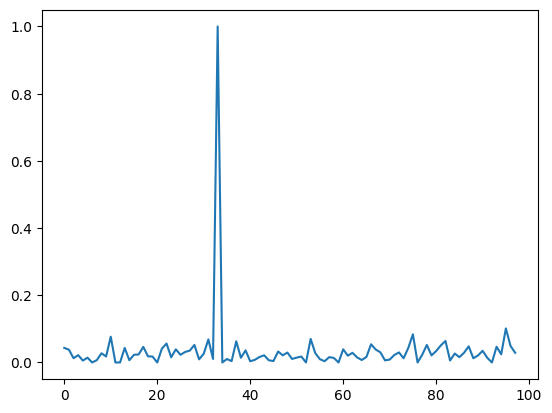

In [18]:
plt.plot(scores)

In [19]:
(-scores).argsort()

array([33, 95, 75, 10, 53, 31, 82, 37, 22, 66, 78, 28, 81, 96, 87, 93, 17,
        0, 13, 74, 21, 60, 24, 67,  1, 39, 27, 90, 80, 46, 26, 68, 72, 48,
       86, 97, 62, 54,  8, 84, 30, 94, 16, 15, 77, 25, 71,  3, 43, 47, 79,
       89, 61, 18,  9, 51, 19, 65, 42, 57, 85, 23, 63, 50,  5, 38, 91, 58,
        2, 88, 73, 32, 49, 35, 55, 29, 70, 41, 64,  7, 14, 44, 69, 83,  4,
       45, 36, 56, 40,  6, 76, 11, 12, 52, 20, 92, 59, 34])

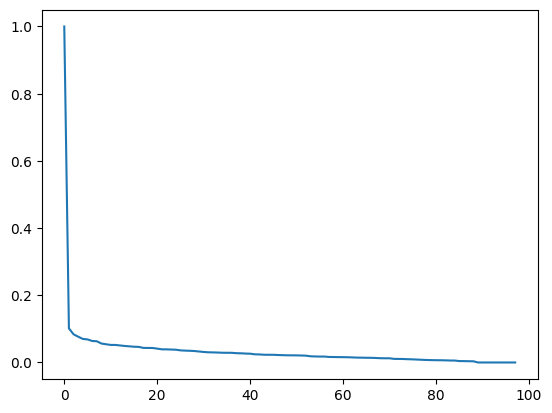

In [20]:
plt.plot(scores[(-scores).argsort()])

In [21]:
#Get the top 10 most similar reviews
top_10 = (-scores).argsort()[:10]
# The - sign is used to sort in descending order

In [22]:
#convert indices to urls
data.iloc[top_10]['url']

33    http://www.imdb.com/title/tt0127388
95    http://www.imdb.com/title/tt0272950
75    http://www.imdb.com/title/tt0277941
10    http://www.imdb.com/title/tt0893406
53    http://www.imdb.com/title/tt0220631
31    http://www.imdb.com/title/tt0127388
82    http://www.imdb.com/title/tt0760179
37    http://www.imdb.com/title/tt0080486
22    http://www.imdb.com/title/tt0479948
66    http://www.imdb.com/title/tt0277941
Name: url, dtype: object

In [23]:
#convert indices to reviews
data.iloc[top_10]['review']

33    skullduggery is a strange  strange film based ...
95    this horrendously bad piece of trash manages t...
75    some funny bits  but come bill  a film  quotin...
10    i felt brain dead  i ll tell you  this is the ...
53    this film is overblown  predictable  pretentio...
31    this was no trainspotting or guy ritchie film ...
82    let s be honest shall we  al gore no more trul...
37    minor spoilers  br    br   well i just sat up ...
22    the king maker will doubtless be a success in ...
66    nightmare weekend is proof positive that some ...
Name: review, dtype: object

**Testing results are saved to a csv**

In [24]:
#Save indices, urls and reviews to a csv file 
with open("top_10.csv", 'w') as f:
    data.iloc[top_10].to_csv(f)

## Vòila, it works!
### Now let us create a function to replicate the results
### e) Ranking by index (because there is no title in the data)

In [25]:
# Function to perform semantic search
def semantic_search(query, tfidf_vectorizer, X, data):
    # Step 1: Convert the query to TF-IDF format
    query_vector = tfidf_vectorizer.transform([query])
    
    # Step 2: Compute the cosine similarity between the query and all the reviews
    cosine_similarities = cosine_similarity(query_vector, X).flatten()
    
    # Step 3: Sort the reviews based on the cosine similarities
    related_docs_indices = cosine_similarities.argsort()[:-6:-1]  # Top 5 most similar reviews
    
    # Display the top 5 most similar reviews
    print("Top 5 most similar reviews to the query: \n")
    for i, index in enumerate(related_docs_indices, 1):
        print(f"{i}. {data.iloc[index]['url']}")
        print(f"Review: {data.iloc[index]['review']}\n")
        print("--------------------------------------------------\n")

# Example usage
user_query = "made me cry"
print(f"Searching for reviews similar to the query: '{user_query}'\n")
semantic_search(user_query, tfidf, X, data)

Searching for reviews similar to the query: 'made me cry'

Top 5 most similar reviews to the query: 

1. http://www.imdb.com/title/tt0272950
Review:  br    br   i am a big time horror sci fi fan regardless of budget  but after watching countless horror movies late night on cable and video  this has to be the worst of all movies  with bloody special effects  what looked like a roast covered in fake blood or ketchup that kept being shown over and over again  and people running around screaming from left  then to right  then back again  it should have stayed with the beginning convenience store scene and stopped there and been 15 minutes  instead  it is dragged out very long  it is very  very x5 low budget  many scenes were way  way too long  narrator sounded very amateurish like a random person out of junior high was talking  this is the only movie to rate lower in my opinion than manos  red zone cuba  benji and godzilla vs  megalon despite their higher budgets  10 snoozes  try to stay a

In [26]:
#Create a function to do the same as above
def recommend(index):
    #Get the vector in the dataframe for an index
    query = X[index]
    #Compute pairwise similarity between the query vector and all the vectors in the dataframe
    scores = cosine_similarity(query, X)
    #Currently the array is 1 x N, make it just a 1-D array
    scores = scores.flatten()
    #Plot the scores
    plt.plot(scores)
    #Plot the scores in descending order
    plt.plot(scores[(-scores).argsort()])
    #Get the top 6 most similar reviews
    top_6 = (-scores).argsort()[0:7]
    #Convert indices to urls
    print(data.iloc[top_6]['url'])
    #Convert indices to reviews
    print(data.iloc[top_6]['review'])
    #Save indices, urls and reviews to a csv file
    with open("top_6_{}.csv".format(index), 'w') as f:
        data.iloc[top_6].to_csv(f,)

Recommendations for index 21:

21    http://www.imdb.com/title/tt0479948
93    http://www.imdb.com/title/tt0272950
89    http://www.imdb.com/title/tt0785025
74    http://www.imdb.com/title/tt0277941
24    http://www.imdb.com/title/tt0479948
30    http://www.imdb.com/title/tt0127388
49    http://www.imdb.com/title/tt0114366
Name: url, dtype: object
21    i should love this movie   the acting is very ...
93    popeye and big foot     popeye s engine compan...
89    this is a movie about making a movie  such mov...
74    the pallbearer is a disappointment and at time...
24    quite possibly the worst movie i ve ever seen ...
30    it is a pity that you cannot vote zero stars o...
49    brief summary  this movie demeans everyone it ...
Name: review, dtype: object
None


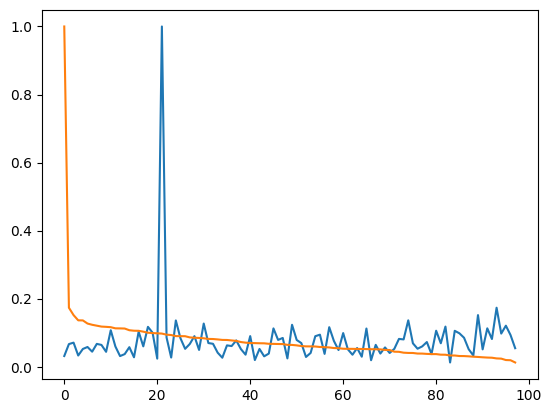

In [27]:
#Please note that the first row is the query itself
print("Recommendations for index 21:\n")
print(recommend(21))

## Finally
### f) Pairwise similarity between movies based on their reviews

In [28]:
# Calculate pairwise cosine similarity among all documents
pairwise_similarity = cosine_similarity(X)

# Convert to DataFrame for easier viewing and manipulation
pairwise_similarity_df = pd.DataFrame(pairwise_similarity, index=grouped['url'], columns=grouped['url'])

# Find the most similar pairs
most_similar_pairs = {}
for i in range(len(pairwise_similarity)):
    for j in range(i+1, len(pairwise_similarity)):
        most_similar_pairs[(grouped.iloc[i]['url'], grouped.iloc[j]['url'])] = pairwise_similarity[i, j]

# Sort the pairs
sorted_similar_pairs = sorted(most_similar_pairs.items(), key=lambda x: x[1], reverse=True)

# Convert to DataFrame and save to CSV
most_similar_df = pd.DataFrame(sorted_similar_pairs, columns=['Movie Pair', 'Cosine Similarity'])
most_similar_df['URL1'], most_similar_df['URL2'] = zip(*most_similar_df['Movie Pair'].apply(lambda x: (x[0], x[1])))
most_similar_df.drop('Movie Pair', axis=1, inplace=True)

most_similar_df.to_csv("most_similar_reviews.csv", index=False)


In [29]:
most_similar_df.head(10)

,Cosine Similarity,URL1,URL2
0,0.250315,http://www.imdb.com/title/tt0311018,http://www.imdb.com/title/tt0949379
1,0.244617,http://www.imdb.com/title/tt0360813,http://www.imdb.com/title/tt0949379
2,0.231119,http://www.imdb.com/title/tt0366292,http://www.imdb.com/title/tt0688816
3,0.220370,http://www.imdb.com/title/tt0291833,http://www.imdb.com/title/tt0463027
4,0.209573,http://www.imdb.com/title/tt0243655,http://www.imdb.com/title/tt0469999
5,0.208294,http://www.imdb.com/title/tt0120764,http://www.imdb.com/title/tt0243655
6,0.203099,http://www.imdb.com/title/tt0025173,http://www.imdb.com/title/tt0262002
7,0.199044,http://www.imdb.com/title/tt0025173,http://www.imdb.com/title/tt0342882
8,0.187861,http://www.imdb.com/title/tt0243655,http://www.imdb.com/title/tt0291833
9,0.186559,http://www.imdb.com/title/tt0366292,http://www.imdb.com/title/tt0463027


In [30]:
# print the reviews for the first 3 pairs 
for i in range(3):
    print(f"Pair {i+1}:")
    print(f"URL1: {most_similar_df.iloc[i]['URL1']}")
    print(f"Review1: {data[data['url']==most_similar_df.iloc[i]['URL1']]['review'].values[0]}")
    print(f"URL2: {most_similar_df.iloc[i]['URL2']}")
    print(f"Review2: {data[data['url']==most_similar_df.iloc[i]['URL2']]['review'].values[0]}")
    print("--------------------------------------------------\n")

Pair 1:
URL1: http://www.imdb.com/title/tt0311018
Review1: if this is someone s  favorite  movie  they need some serious help  there is nothing funny or clever about this crapfest  i haven t seen the original movie this is the remake of  some 1950s film   but it simply has to be better than this newer bastardization  br    br   a major gets kicked out of the military for being a fringe element  and winds up teaching children at an rotc school  unfortunately  the major is daman wayans    so the children are in for a world of annoying  humorless asininity  can wayans whip these losers into shape  can they get him to become a little more human  the film bombs as most wayans films do  with only a few sparkling moments  william hickey gets about one minute of screen time  fair too little  this charming old man  known best to me as a  tales from the crypt  actor  known best to you as uncle louis from  christmas vacation   shines every moment he s on screen  which isn t much here  br    br   

In [31]:
positive_words = ['good', 'great', 'awesome', 'fantastic', 'terrific', 'excellent']
negative_words = ['bad', 'terrible', 'awful', 'poor', 'horrible']

def calculate_sentiment(review):
    pos_count = sum(1 for word in review.split() if word in positive_words)
    neg_count = sum(1 for word in review.split() if word in negative_words)
    
    if pos_count > neg_count:
        return 'positive'
    elif pos_count < neg_count:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis function to your sample reviews
random_sample_df['sentiment'] = random_sample_df['review'].apply(calculate_sentiment)

# Count the number of each type of review
sentiment_counts = random_sample_df['sentiment'].value_counts()

print(sentiment_counts)

sentiment
negative    40
neutral     33
positive    27
Name: count, dtype: int64
